# Lesson 5: Manipulating data with `pandas`

## 06/11/2020

In today's lesson we're going to explore some of the `pandas` package features that allow the manipulation of data frames for data analysis.

The goals of this lesson are:
- Put to use some of the lessons we've learned so far
- use `groupby` to collapse variables
- use `researchpy` to get summary statistics
- use `statsmodel` to run t-tests and anovas

## 5.0) Create data

We're going to use `pandas` to create a data frame with some fake data. This will also serve as a recap of the loops and functions lesson from last week.

The experiment is one where researchers are interested in the influence of mindfulness meditation on visual search. The hypothesis is that meditation will have an acute effect on visual search by facilitating the suppression of distractors.

10 people without any prior mindfulness training came on two separate days to do a visual search experiment. On one of the days they participated in a 20 minute guided meditation session, whereas on the other day they sat in a room for 20 minutes without any instruction. 

They then participated in a visual search task where they had to locate a square amongst circles. On each trial the number of circles could be 6, 12, or 18. The dependent variable was the time it took for each participant to locate the square.

So here we have a 2x3 repeated measures design (meditation by set size).

Let create some fake data below

In [185]:
import pandas as pd
import numpy as np

ntrials = 10
subID = 1

# Generate a sequence of set sizes and condition markers
set_size = [6]*ntrials+[12]*ntrials+[18]*ntrials
condition = np.array(['mindfulness']*len(set_size)+['none']*len(set_size))
set_size = np.array(set_size+set_size) # adjust set size length

# Generate response times with interactive effect
# My simulated log response time means
logRTmeans_set = {'6mindfulness': 5.5,
                  '12mindfulness':7,
                  '18mindfulness':7.5,
                  '6none': 5.5,
                  '12none':7.5,
                  '18none':8}

# Empty list where I will add my simulated response times
logrt = np.zeros(len(set_size))
for s in np.unique(set_size):
    for c in np.unique(condition):
        key=str(s)+c
        #Generate sample from normal distribution - first argument is mean, second SD
#         print(np.random.normal(logRTmeans_set[key],1.2,10)) 
        #print(len(logrt[(set_size == s) & (condition == c)]))
        logrt[(set_size == s) & (condition == c)] = np.random.normal(logRTmeans_set[key],1.2,len(logrt[(set_size == s) & (condition == c)]))
#print(logrt)   
df = pd.DataFrame(
    {
        'Subject': np.array([subID]*len(set_size)).astype(str),
        'Condition': condition,
        'Set_Size': set_size,
        'RT': np.exp(logrt)
    }
)
df

Subject    Condition  Set_Size            RT
0        1  mindfulness         6    327.306567
1        1  mindfulness         6    221.667455
2        1  mindfulness         6    609.242010
3        1  mindfulness         6    310.959462
4        1  mindfulness         6    135.212288
5        1  mindfulness         6   1090.320015
6        1  mindfulness         6    475.512981
7        1  mindfulness         6    482.302988
8        1  mindfulness         6    329.081844
9        1  mindfulness         6    435.375667
10       1  mindfulness        12    610.764324
11       1  mindfulness        12   1710.272935
12       1  mindfulness        12   4130.143560
13       1  mindfulness        12    168.484420
14       1  mindfulness        12   2019.819125
15       1  mindfulness        12   1050.400525
16       1  mindfulness        12   2173.863561
17       1  mindfulness        12    262.637929
18       1  mindfulness        12    692.114558
19       1  mindfulness        12    623.917719
20       1  mindfulness        18   2866.619645
21       1  mindfulness        18   6416.634480
22       1  mindfulness        18    957.190148
23       1  mindfulness        18   8021.155549
24       1  mindfulness        18   3498.909776
25       1  mindfulness        18   4913.090568
26       1  mindfulness        18   1229.327334
27       1  mindfulness        18    510.380493
28       1  mindfulness        18   6344.550821
29       1  mindfulness        18   1385.800204
30       1         none         6    107.465580
31       1         none         6    362.549358
32       1         none         6    510.828836
33       1         none         6    172.650760
34       1         none         6    335.935350
35       1         none         6    364.189655
36       1         none         6    466.797773
37       1         none         6    795.150872
38       1         none         6    114.772688
39       1         none         6    110.347128
40       1         none        12   1091.268050
41       1         none        12  10552.926434
42       1         none        12    331.075764
43       1         none        12   1411.127398
44       1         none        12    828.257214
45       1         none        12   1051.364418
46       1         none        12    194.337410
47       1         none        12   5390.231902
48       1         none        12   7452.021255
49       1         none        12   7723.452984
50       1         none        18   1729.064202
51       1         none        18   3563.589041
52       1         none        18  28301.147413
53       1         none        18     87.981443
54       1         none        18   5661.201103
55       1         none        18  14231.518711
56       1         none        18  11838.202475
57       1         none        18  11093.374912
58       1         none        18   2476.208567
59       1         none        18   5904.448591

In [189]:
import pandas as pd
import numpy as np

# Create a function that generates data from one subject
def gen_vis_search_sub(subID,ntrials):
    '''
    Function to create trials for one subject doing a visual seach task
    INPUT:
    subID - the subject identifier
    ntrials - number of trials per set size
    
    OUTPUT:
    df - pandas data frame with columns Subject, Condition, Trial Set Size, and response time
    '''
    
    # First, generate a sequence of set sizes and conditions
    set_size = [6]*ntrials+[12]*ntrials+[18]*ntrials
    condition = np.array(['mindfulness']*len(set_size)+['none']*len(set_size))
    set_size = np.array(set_size+set_size)
    
    # Generate response times with interactive effect
    logrt = np.zeros(len(set_size))
    logRTmeans_set = {'6mindfulness': 5.5,'12mindfulness':7,'18mindfulness':7.5, 
                      '6none': 5.5,'12none':7.5,'18none':8}
    for s in np.unique(set_size):
        for c in np.unique(condition):
            key=str(s)+c
            logrt[(set_size == s) & (condition == c)] = np.random.normal(logRTmeans_set[key],1.2,len(logrt[(set_size == s) & (condition == c)]))
    
    # Save subject simulations into a data frame
    df = pd.DataFrame(
        {
            'Subject': np.array([subID]*len(set_size)).astype(str),
            'Condition': condition,
            'Set_Size': set_size,
            'RT': np.exp(logrt)
        }
    )
    return(df)

# Create a data frame with data from 10 subjects having performed 20 trials per set
np.random.seed(321) #makes sure we all get the same results
ntrials = 200
nsub = 10
subdf = gen_vis_search_sub(1,ntrials)
for s in range(2,nsub+1):
    subdf = subdf.append(gen_vis_search_sub(s,ntrials),ignore_index=True)
subdf

Subject    Condition  Set_Size           RT
0           1  mindfulness         6   300.973844
1           1  mindfulness         6  1741.634012
2           1  mindfulness         6   255.904335
3           1  mindfulness         6    84.691935
4           1  mindfulness         6    62.064198
...       ...          ...       ...          ...
11995      10         none        18   338.730144
11996      10         none        18  3379.732081
11997      10         none        18  1498.492416
11998      10         none        18  7143.689362
11999      10         none        18  2373.356371

[12000 rows x 4 columns]

We now have data. One of the issues however is that we know RTs aren't normally distributed (a fact we baked in to our fake data).

The code below adds a column to our data frame that takes the log of our RTs. To ensure that they are normally distributed.

Text(0.5, 0, 'log Response Times')

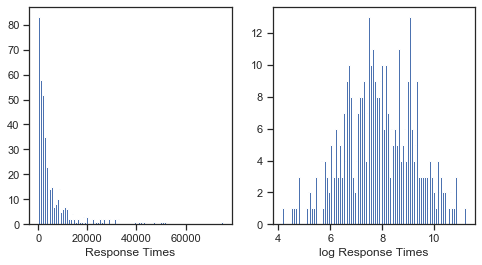

In [190]:
subdf['logRT'] = np.log(subdf['RT'])

# Plot the difference for one subject for one condition
s1 = subdf.loc[(subdf['Subject'] == '1') & (subdf['Set_Size'] == 18)]
import matplotlib.pyplot as plt

plt.figure(1,(8,4))
plt.subplot(1,2,1)
plt.hist(s1['RT'],100)
plt.xlabel('Response Times')

plt.subplot(1,2,2)
plt.hist(s1['logRT'],100)
plt.xlabel('log Response Times')

## 5.1) Summarizing the data

So what we've generated is s bunch of trial by trial data for each subject. A next step would be to summarize the data so that we have mean logRT values for each subject for each condition. This can be done using the `grouby` function from `pandas`.

In [117]:
subdf_meanrt = subdf.groupby(['Subject','Condition','Set_Size'],as_index=False).mean()
print(subdf_meanrt.head(10))

  Subject    Condition  Set_Size           RT     logRT
0       1  mindfulness         6   366.620911  5.222295
1       1  mindfulness        12  2434.840905  7.225107
2       1  mindfulness        18  5145.272559  7.393896
3       1         none         6   318.299530  5.312889
4       1         none        12  3129.291301  7.638754
5       1         none        18  6092.804222  8.065632
6      10  mindfulness         6   569.111367  5.691968
7      10  mindfulness        12  2522.925356  7.039098
8      10  mindfulness        18  5235.608918  7.772215
9      10         none         6   371.983113  5.190134


We can then go further and get the summary statistics we want for each set size across subjects.

In [59]:
alldf_meanrt = subdf_meanrt.groupby(['Condition','Set_Size'],as_index=False).mean()
alldf_meanrt

Condition  Set_Size           RT     logRT
0  mindfulness         6   432.667171  5.573433
1  mindfulness        12  1882.627933  7.048772
2  mindfulness        18  2835.195918  7.481382
3         none         6   407.177674  5.513879
4         none        12  2774.895790  7.481072
5         none        18  4640.081949  7.988413

In addition to `mean()` there are a few other built in function that can be use (e.g., `sum`, `count`,`min`,`max`,`sem` - the full list can be found [here](https://cmdlinetips.com/2019/10/pandas-groupby-13-functions-to-aggregate/)). You can additionally use the `agg` function, which allows the use of a few different functions all in one line.

In [60]:
alldf_mean_sd_rt = subdf_meanrt.groupby(['Condition','Set_Size']).agg(['mean','std','sem'])
alldf_mean_sd_rt

# Hierachical indexing
#print(alldf_mean_sd_rt['RT']['mean'])

RT                             logRT            \
                             mean         std         sem      mean       std   
Condition   Set_Size                                                            
mindfulness 6          432.667171   56.729361   17.939399  5.573433  0.098003   
            12        1882.627933  187.414385   59.265632  7.048772  0.116226   
            18        2835.195918  220.675644   69.783766  7.481382  0.079015   
none        6          407.177674   34.101699   10.783904  5.513879  0.091539   
            12        2774.895790  390.842857  123.595363  7.481072  0.126725   
            18        4640.081949  510.274914  161.363096  7.988413  0.095317   

                                
                           sem  
Condition   Set_Size            
mindfulness 6         0.030991  
            12        0.036754  
            18        0.024987  
none        6         0.028947  
            12        0.040074  
            18        0.030142

If you want to go beyond the defaults that are provided and use your own function, you can use the `apply` function.

In [61]:
def get_std_p3(x):
    return(np.std(x)+3)

subdf_meanrt.groupby(['Condition','Set_Size']).apply(get_std_p3)

Set_Size          RT     logRT
Condition   Set_Size                                
mindfulness 6              3.0   56.818197  3.092974
            12             3.0  180.796896  3.110262
            18             3.0  212.351298  3.074960
none        6              3.0   35.351712  3.086842
            12             3.0  373.786090  3.120222
            18             3.0  487.089288  3.090426

Another handy package for summarize is called `researchpy`, and is available to install on pip and using conda
> `pip install researchpy`
or
> `conda install researchpy`

This package has a few functions that work well with pandas data frames to provide a lot of the summary statistics we're interested in as researchers.

In [62]:
import researchpy as rp
print(subdf_meanrt.head(10))

# Get summary of all logRTs
rp.summary_cont(subdf_meanrt['logRT'])

# # Get summary of all logRTs in each condition collapsed across set size
# rp.summary_cont(subdf_meanrt.groupby(['Condition'])['logRT'])

# # Get summary of logRTs for each condition and set size
# rp.summary_cont(subdf_meanrt.groupby(['Condition','Set_Size'])['logRT'])

  Subject    Condition  Set_Size           RT     logRT
0       1  mindfulness         6   458.328919  5.527109
1       1  mindfulness        12  1672.219100  6.904869
2       1  mindfulness        18  3008.716084  7.527930
3       1         none         6   376.133941  5.480464
4       1         none        12  2347.947924  7.366408
5       1         none        18  5204.917019  8.108218
6      10  mindfulness         6   370.319760  5.418266
7      10  mindfulness        12  1981.521566  7.048917
8      10  mindfulness        18  2696.289490  7.492682
9      10         none         6   455.092905  5.661852




Variable     N      Mean        SD        SE  95% Conf.  Interval
0    logRT  60.0  6.847825  0.974575  0.125817   6.596066  7.099584

## 5.2) Basic stats

Now that we have some summary statistics, lets do some stats. Given that we have a 2x3 repeated measures design, let's choose the appropriate stats package. There are a few available in python, but one that is commonly used is `statsmodels`. You can install `statsmodels` using `pip` or `conda` install methods.

In [133]:
from statsmodels.stats.anova import AnovaRM

Starting from our raw data `subdf`, lets get things into the shape we need.

In [134]:
# Take the log of the RT
subdf['logRT'] = np.log(subdf['RT'])

# Get data frame with mean logRT for each subject for each set size for each condition
subdf_means = subdf[['Subject','Condition','Set_Size','logRT']].groupby(['Subject','Condition','Set_Size'],as_index=False).mean()
subdf_means.head(10)

Subject    Condition  Set_Size     logRT
0       1  mindfulness         6  5.458588
1       1  mindfulness        12  7.021841
2       1  mindfulness        18  7.495083
3       1         none         6  5.576858
4       1         none        12  7.448525
5       1         none        18  8.064247
6      10  mindfulness         6  5.500399
7      10  mindfulness        12  6.895104
8      10  mindfulness        18  7.435550
9      10         none         6  5.614180

In [135]:
# Get summary statistics - reset index necessary for the plotting
subdf_means_summ = rp.summary_cont(subdf_means.groupby(['Condition','Set_Size'],as_index=False)['logRT']).reset_index()
subdf_means_summ

Condition  Set_Size   N      Mean        SD        SE  95% Conf.  \
0  mindfulness         6  10  5.547183  0.078827  0.024927   5.498326   
1  mindfulness        12  10  6.995594  0.086178  0.027252   6.942180   
2  mindfulness        18  10  7.467221  0.138975  0.043948   7.381084   
3         none         6  10  5.481337  0.122945  0.038879   5.405135   
4         none        12  10  7.523540  0.075105  0.023750   7.476990   
5         none        18  10  7.974743  0.117679  0.037214   7.901805   

   Interval  
0  5.596041  
1  7.049008  
2  7.553358  
3  5.557539  
4  7.570091  
5  8.047682

Text(0.5, 0, 'Set Size')

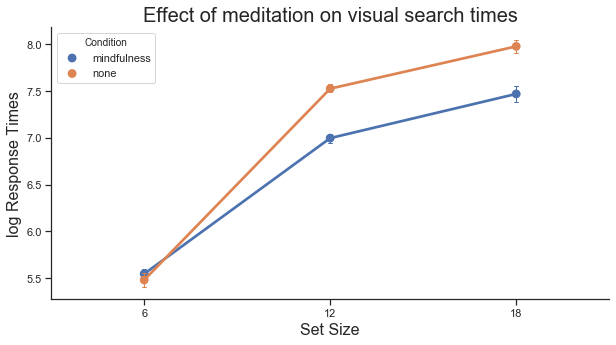

In [136]:
# Visualize means
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style('ticks')


plt.figure(1,(10,5))
sns.pointplot(x='Set_Size',y='logRT',hue='Condition',data=subdf_means,capsize=.02,errwidth=1)
sns.despine()
plt.title('Effect of meditation on visual search times',size=20)
plt.ylabel('log Response Times',size=16)
plt.xlabel('Set Size',size=16)

In [137]:
# Run repeated measures ANOVA
subdf_means_aov = AnovaRM(subdf_means,depvar='logRT',subject = 'Subject',within=['Condition','Set_Size'])
subdf_means_aov_fit = subdf_means_aov.fit()

print(subdf_means_aov_fit)

                      Anova
                    F Value  Num DF  Den DF Pr > F
--------------------------------------------------
Condition           115.1351 1.0000  9.0000 0.0000
Set_Size           1997.2817 2.0000 18.0000 0.0000
Condition:Set_Size   84.2273 2.0000 18.0000 0.0000



In [138]:
# T-test for difference in logRT at each set size
from scipy import stats

print('T-tests difference between mindfulness and none\n')
for s in pd.unique(subdf_means['Set_Size']):
    print('Set size = '+str(s))
    tt = stats.ttest_rel(subdf_means['logRT'].loc[(subdf_means['Condition'] == 'mindfulness') & (subdf_means['Set_Size'] == s)],
               subdf_means['logRT'].loc[(subdf_means['Condition'] == 'none') & (subdf_means['Set_Size'] == s)])
    print(tt)

T-tests difference between mindfulness and none

Set size = 6
Ttest_relResult(statistic=1.367085546341318, pvalue=0.2047686762696307)
Set size = 12
Ttest_relResult(statistic=-16.372710520804297, pvalue=5.2614097417642834e-08)
Set size = 18
Ttest_relResult(statistic=-11.181160668858546, pvalue=1.402560699777167e-06)
